In [1]:
import numpy as np, os
from matplotlib import pyplot as plt
import h5py as h5

%matplotlib inline

In [2]:
bpass_data_dir = '../data/BPASS/BPASSv2.2/'
geneva_data_dir = '../data/Geneva/ncounts/'
genevabcrit_data_dir = '../data/Geneva_Bcrit/ncounts/'

In [3]:
modeltypes = ['sin','bin','rot','not']
zs = ['z0004','zem5','zem4','z001','z002','z004','z006','z008','z010','z014','z020','z030','z040']
cols_dict = {'O':(1,),'Of':(2,),'B':(3,),'A':(4,),'FG':(5,),'K':(6,),'M':(7,),'WNH':(8,),'WN':(9,),'WC':(10,),'RSG':(6,7),'WR':(8,9,10),'BSG':(1,2,3,4),'YSG':(5,)}
subtypes = list(cols_dict.keys())
Lcuts = [0.0] + [3.0 + 0.1*i for i in range(31)]
models = ['BPASS','Geneva','Geneva_BPASS_crit']

In [4]:
def data_file_lookup(modeltype, z, subtype, Lcut = 0.0, tracks='BPASS'):
    """
    Gets the number counts vs. time arrays from data_dir
    
    Parameters
    ----------
    modeltype : str
        'sin' or 'bin' indicating 100% singles or 100% binaries
    z : str
        Metallicity. Formatted like BPASS.
    subtype : str
        Stellar subtype. Must be in subtypes array
    L_cut : float
        Lower luminosity cutoff. Can be 0.0 (default), or between 3.0 and 5.0 in 
        steps of 0.1
    tracks : str
        Evolutionary code. Must be in either 'BPASS' or 'Geneva'. Default 'BPASS'
    """
    
    assert modeltype in modeltypes, "modeltypes must be 'sin' or 'bin'"
    
    assert z in zs, "z must be a valid BPASS metallicity"
    
    assert subtype in subtypes, "subtype must be a valid subtype in subtypes"
    
    assert Lcut in Lcuts, "L_cut must be 0.0, or between 3.0 and 5.0 in steps of 0.1"
    
    assert tracks in models, "tracks must be 'BPASS' or 'Geneva'"
    
    if tracks == 'BPASS':
        data_dir = bpass_data_dir
    elif tracks == 'Geneva':
        data_dir = geneva_data_dir
    else:
        data_dir = genevabcrit_data_dir
    
    filename = data_dir+'ncounts_{0}_{1}_{2}.dat'.format(z, modeltype, int(10*Lcut))

    assert os.path.exists(filename), "Something is wrong and I can't find the datafile you want"
    
    cols = tuple([0]+list(cols_dict[subtype]))
    
    data = np.genfromtxt(filename, usecols=cols)
    
    logtime = data[:,0]
    ncounts = np.sum(data[:,1:],axis=1)
    return logtime,ncounts

(6, 7)

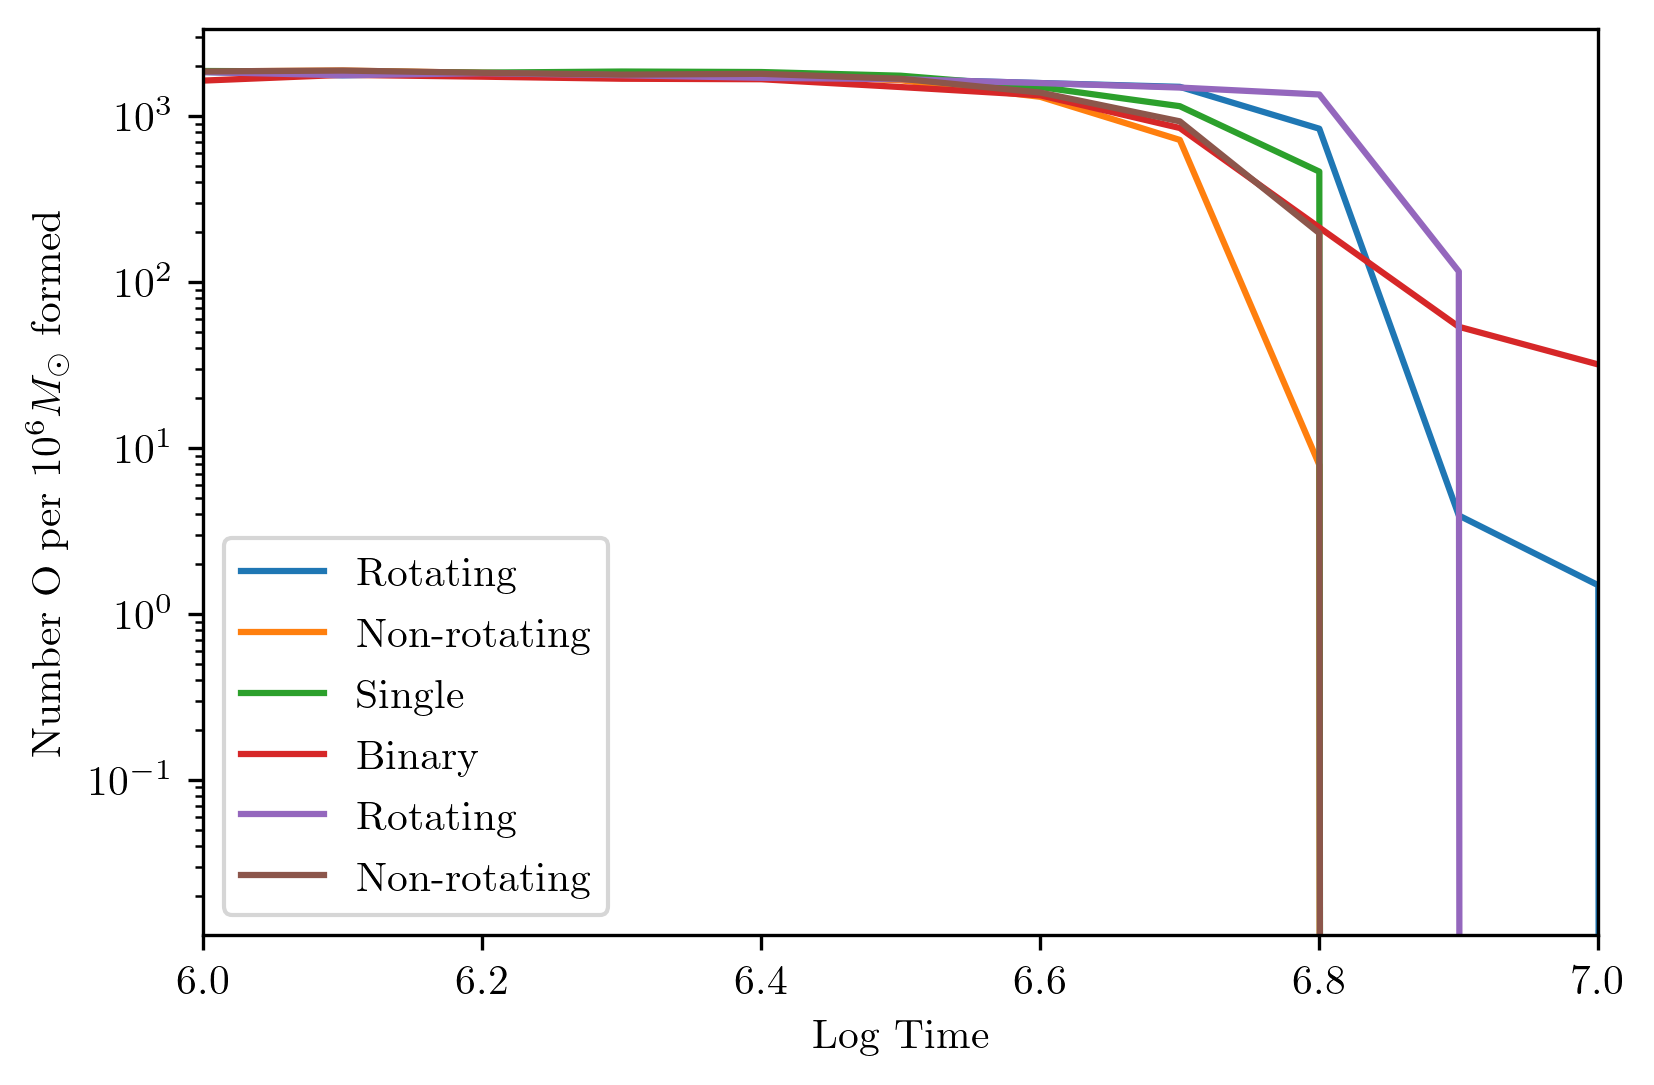

In [5]:
#looks like this works?
fig = plt.figure(dpi=300)
logtime,ncounts = data_file_lookup('rot','z014', 'O', Lcut=4.9, tracks='Geneva')
plt.semilogy(logtime,ncounts,label='Rotating')
logtime,ncounts = data_file_lookup('not','z014', 'O', Lcut=4.9, tracks='Geneva')
plt.semilogy(logtime,ncounts,label='Non-rotating')
logtime,ncounts = data_file_lookup('sin','z014', 'O', Lcut=4.9)
plt.semilogy(logtime,ncounts,label='Single')
logtime,ncounts = data_file_lookup('bin','z014', 'O', Lcut=4.9)
plt.semilogy(logtime,ncounts,label='Binary')
logtime,ncounts = data_file_lookup('rot','z014', 'O', Lcut=4.9, tracks='Geneva_BPASS_crit')
plt.semilogy(logtime,ncounts,label='Rotating')
logtime,ncounts = data_file_lookup('not','z014', 'O', Lcut=4.9, tracks='Geneva_BPASS_crit')
plt.semilogy(logtime,ncounts,label='Non-rotating')
plt.legend()
plt.xlabel('Log Time')
plt.ylabel('Number O per $10^6 M_\odot$ formed')
plt.xlim(6,7)

In [6]:
#This cell creates the file from scratch!! Don't run it if you don't need it.
try:
    ncounts_h5.close()
except:
    pass
ncounts_h5 = h5.File("ncounts.hdf5", "w")
ncounts_h5.create_dataset('logtime', data=logtime)
ncounts_h5.create_dataset('meta', shape=(0,), dtype=int)
ncounts_h5['meta'].attrs.create('modeltypes',[a.encode('utf8') for a in modeltypes])
ncounts_h5['meta'].attrs.create('zs',[a.encode('utf8') for a in zs])
ncounts_h5['meta'].attrs.create('subtypes',[a.encode('utf8') for a in subtypes])
ncounts_h5['meta'].attrs.create('Lcuts',Lcuts)
ncounts_h5['meta'].attrs.create('models',[a.encode('utf8') for a in models])
for model in models:
    
    if model in ['Geneva','Geneva_BPASS_crit']:
        modtypes = ['rot','not']
    else:
        modtypes = ['sin','bin']
        
    for modtype in modtypes:
        for z in zs:
            for subtype in subtypes:
                for Lcut in Lcuts:
                    if (modtype in ['sin','bin']) and (z == 'z0004'):
                        pass
                    elif (modtype in ['rot','not']) and (z not in ['z0004','z002','z014']):
                        pass
                    else:
                        try: #just in case any of the files you need are missing
                            logtime,ncounts = data_file_lookup(modtype,z,subtype,Lcut=Lcut,tracks=model)
                        except:
                            print(modtype,z,subtype,Lcut)
                        ncounts_h5.create_dataset('{0}/{1}/{2}/{3}/{4}/ncounts'.format(model,modtype,z,subtype,str(Lcut)),data=ncounts)
                        ncounts_h5['{0}/{1}/{2}/{3}/{4}/ncounts'.format(model,modtype,z,subtype,str(Lcut))].attrs['tracks'] = model
                        ncounts_h5['{0}/{1}/{2}/{3}/{4}/ncounts'.format(model,modtype,z,subtype,str(Lcut))].attrs['modeltype'] = modtype
                        ncounts_h5['{0}/{1}/{2}/{3}/{4}/ncounts'.format(model,modtype,z,subtype,str(Lcut))].attrs['z'] = z
                        ncounts_h5['{0}/{1}/{2}/{3}/{4}/ncounts'.format(model,modtype,z,subtype,str(Lcut))].attrs['subtype'] = subtype
                        ncounts_h5['{0}/{1}/{2}/{3}/{4}/ncounts'.format(model,modtype,z,subtype,str(Lcut))].attrs['Lcut'] = Lcut
ncounts_h5.close()

In [7]:
ncounts = h5.File('ncounts.hdf5','r')
print(list(ncounts['meta'].attrs))
ncounts.close()

['Lcuts', 'models', 'modeltypes', 'subtypes', 'zs']
